# LINEAR REGRESSION

In [116]:
# IMPORTING NECESSARY LIBRARIES
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

**BRIEF**

- Output = activation(dot(input, kernel) + bias

That looks familiar doesn't it? It looks almost identical to y = mx+b. The dot product is sum of the products in two sequences. Well, if there is only two sequences with a length of 1 then it is just the product of those two numbers. This simplifies down to the all to familiar y = mx + b.


## Setup

In [117]:
# Example of dot product of two sequences of length 1
np.dot(2,1) + 5

7

In [118]:
# IMPORTING NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [119]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Timestamp in Days")
    plt.ylabel("Rupees")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 20-step windows for training. Every 20 steps is 1 trading month since the markets are only open Sunday - Thursday which is 20 days a week.

In [120]:
# Read in data
nabil = pd.read_csv('../Data/NABILModifiedDate.csv')

# Convert series into datetime type
nabil['Date'] = pd.to_datetime(nabil['Date'])

# Save target series
series = nabil['Close']

# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(nabil.Date == train_split_date)[0][0]
x_train = nabil.loc[nabil['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-01-03'
test_split_index = np.where(nabil.Date == test_split_date)[0][0]
x_test = nabil.loc[nabil['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = nabil.loc[(nabil['Date'] < test_split_date) & (nabil['Date'] > train_split_date)]['Close']

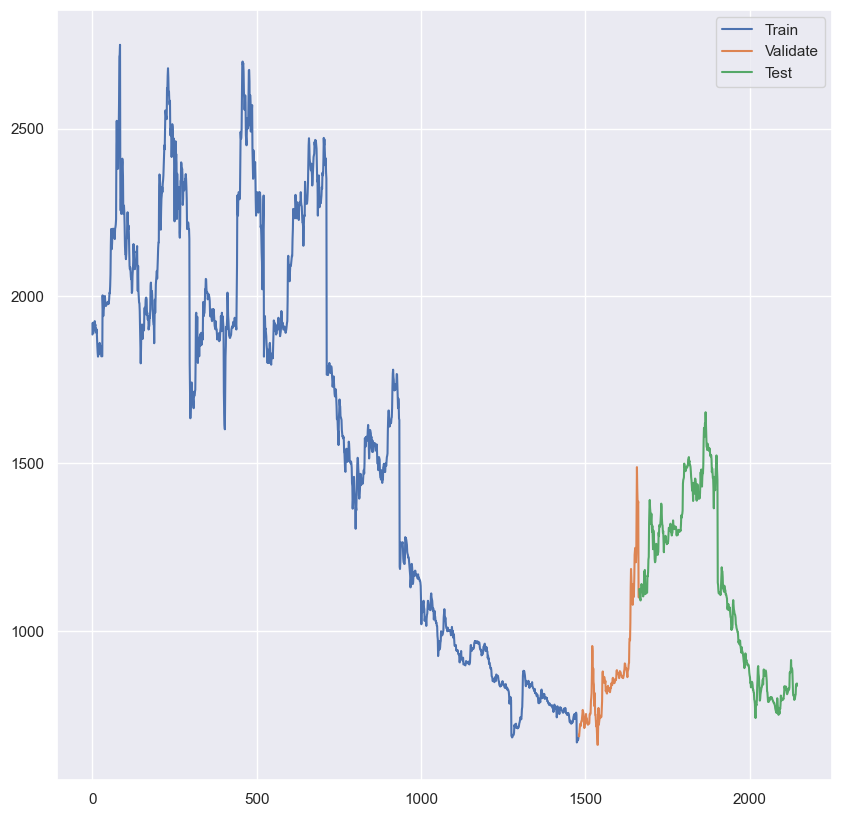

1479 1480 1663 1664 2144


<Figure size 1000x1000 with 0 Axes>

In [121]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
plt.show()
plt.savefig('../Images/LINEAR/LINEAR REGRESSION TRAIN TEST SPLIT')
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [122]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
nabil_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

### Linear Model

In [123]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Clears any background saved info useful in notebooks
keras.backend.clear_session()

# Make reproducible
tf.random.set_seed(42)
np.random.seed(42)

# set window size 
window_size = 20

# define training data (20 day windows shifted by 1 every time)
train_set = window_dataset(normalized_x_train.flatten(), window_size)

# Build Linear Model of a single dense layer
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])

# Find optimal learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.legacy.Nadam(learning_rate=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.0000e-06
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.0798e-06
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.1659e-06
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.2589e-06
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.3594e-06
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.4678e-06
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.5849e-06
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.7113e-06
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0049 - mae: 0.0625 - lr: 1.8478e-06
E

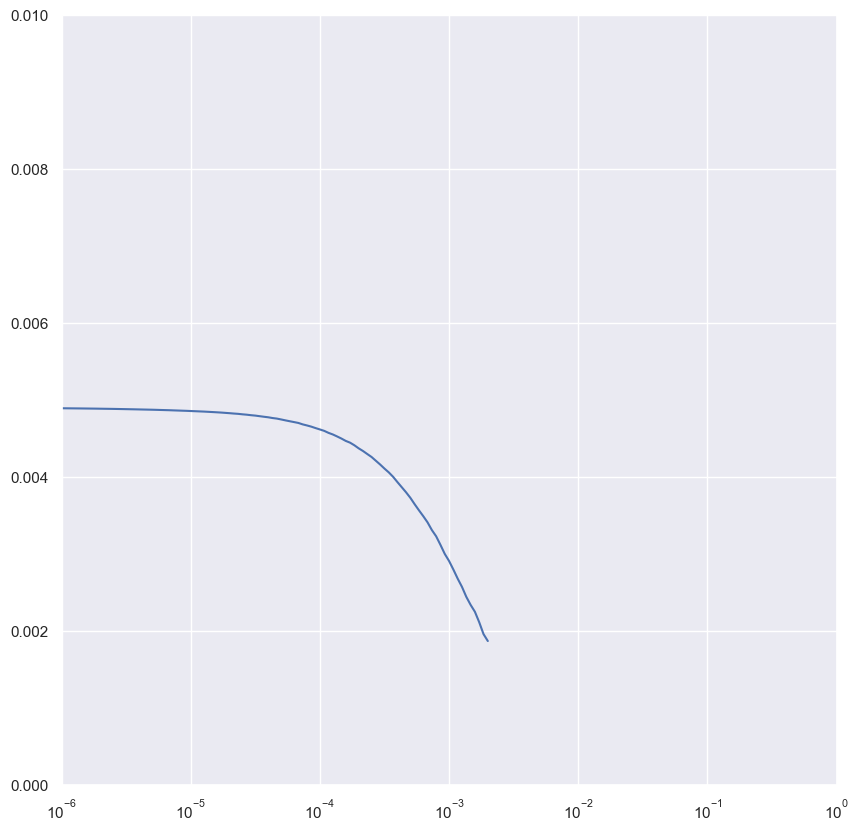

In [124]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .01])
plt.savefig('../Images/LINEAR/LINEAR REGRESSION LEARNING RATE')

In [125]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Useful to clear everything when rerunning cells
keras.backend.clear_session()

# Make this reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Create train and validate windows
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# 1 layer producing linear output for 1 output from each window of 20 days
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size]) # o
])

# Huber works well with "mae"
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-3)  # Use the legacy Nadam optimizer with learning_rate argument
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# fit model to data
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])


Epoch 1/500
      6/Unknown - 0s 11ms/step - loss: 0.0301 - mae: 0.2023 INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 1s 31ms/step - loss: 0.0250 - mae: 0.1780 - val_loss: 0.0031 - val_mae: 0.0537
Epoch 2/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0190 - mae: 0.1665INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0100 - mae: 0.1057 - val_loss: 0.0021 - val_mae: 0.0417
Epoch 3/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0085 - mae: 0.1034INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0041 - mae: 0.0621 - val_loss: 0.0018 - val_mae: 0.0398
Epoch 4/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0051 - mae: 0.0655INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0032 - mae: 0.0527 - val_loss: 0.0017 - val_mae: 0.0400
Epoch 5/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0041 - mae: 0.0628INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0032 - mae: 0.0525 - val_loss: 0.0017 - val_mae: 0.0398
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0032 - mae: 0.0520 - val_loss: 0.0017 - val_mae: 0.0395
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0032 - mae: 0.0517 - val_loss: 0.0017 - val_mae: 0.0392
Epoch 8/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0031 - mae: 0.0513 - val_loss: 0.0017 - val_mae: 0.0390
Epoch 9/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0031 - mae: 0.0510 - val_loss: 0.0017 - val_mae: 0.0388
Epoch 10/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0031 - mae: 0.0508 - val_loss: 0.0017 - val_mae: 0.0386
Epoch 11/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0031 - mae: 0.0505 - val_loss: 0.0017 - val_mae: 0.0384
Epoch 12/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0037 - mae: 0.0595IN

INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0502 - val_loss: 0.0017 - val_mae: 0.0382
Epoch 13/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0032 - mae: 0.0581INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0499 - val_loss: 0.0017 - val_mae: 0.0381
Epoch 14/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0034 - mae: 0.0575INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0496 - val_loss: 0.0017 - val_mae: 0.0379
Epoch 15/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0052 - mae: 0.0665INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0493 - val_loss: 0.0017 - val_mae: 0.0378
Epoch 16/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0037 - mae: 0.0615INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0490 - val_loss: 0.0017 - val_mae: 0.0377
Epoch 17/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0487 - val_loss: 0.0017 - val_mae: 0.0377
Epoch 18/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0484 - val_loss: 0.0017 - val_mae: 0.0375
Epoch 19/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0038 - mae: 0.0543INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0029 - mae: 0.0481 - val_loss: 0.0017 - val_mae: 0.0374
Epoch 20/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0479 - val_loss: 0.0017 - val_mae: 0.0375
Epoch 21/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0476 - val_loss: 0.0017 - val_mae: 0.0375
Epoch 22/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0040 - mae: 0.0579INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0029 - mae: 0.0473 - val_loss: 0.0017 - val_mae: 0.0373
Epoch 23/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 0.0471 - val_loss: 0.0017 - val_mae: 0.0375
Epoch 24/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0039 - mae: 0.0591INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0028 - mae: 0.0468 - val_loss: 0.0017 - val_mae: 0.0373
Epoch 25/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 0.0465 - val_loss: 0.0017 - val_mae: 0.0375
Epoch 26/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0040 - mae: 0.0558INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0028 - mae: 0.0463 - val_loss: 0.0017 - val_mae: 0.0372
Epoch 27/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0041 - mae: 0.0599INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0027 - mae: 0.0460 - val_loss: 0.0017 - val_mae: 0.0371
Epoch 28/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0027 - mae: 0.0458 - val_loss: 0.0017 - val_mae: 0.0372
Epoch 29/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0032 - mae: 0.0553INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0027 - mae: 0.0455 - val_loss: 0.0016 - val_mae: 0.0370
Epoch 30/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0027 - mae: 0.0453 - val_loss: 0.0017 - val_mae: 0.0372
Epoch 31/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0026 - mae: 0.0451 - val_loss: 0.0016 - val_mae: 0.0371
Epoch 32/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0045 - mae: 0.0643INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0026 - mae: 0.0449 - val_loss: 0.0016 - val_mae: 0.0369
Epoch 33/500
 1/12 [=>............................] - ETA: 1s - loss: 0.0036 - mae: 0.0617INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 23ms/step - loss: 0.0026 - mae: 0.0446 - val_loss: 0.0016 - val_mae: 0.0369
Epoch 34/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0026 - mae: 0.0464INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0026 - mae: 0.0445 - val_loss: 0.0016 - val_mae: 0.0367
Epoch 35/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0048 - mae: 0.0642INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0026 - mae: 0.0442 - val_loss: 0.0016 - val_mae: 0.0367
Epoch 36/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0025 - mae: 0.0440 - val_loss: 0.0016 - val_mae: 0.0369
Epoch 37/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0043 - mae: 0.0584INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0025 - mae: 0.0439 - val_loss: 0.0016 - val_mae: 0.0363
Epoch 38/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0025 - mae: 0.0435 - val_loss: 0.0016 - val_mae: 0.0366
Epoch 39/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0036 - mae: 0.0531INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0025 - mae: 0.0434 - val_loss: 0.0016 - val_mae: 0.0364
Epoch 40/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0024 - mae: 0.0432 - val_loss: 0.0016 - val_mae: 0.0365
Epoch 41/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0030 - mae: 0.0493INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0024 - mae: 0.0430 - val_loss: 0.0015 - val_mae: 0.0358
Epoch 42/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0024 - mae: 0.0428 - val_loss: 0.0015 - val_mae: 0.0360
Epoch 43/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0024 - mae: 0.0426 - val_loss: 0.0015 - val_mae: 0.0362
Epoch 44/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0028 - mae: 0.0489INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0024 - mae: 0.0424 - val_loss: 0.0015 - val_mae: 0.0359
Epoch 45/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0035 - mae: 0.0556INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0023 - mae: 0.0421 - val_loss: 0.0015 - val_mae: 0.0353
Epoch 46/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0023 - mae: 0.0419 - val_loss: 0.0015 - val_mae: 0.0354
Epoch 47/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0039 - mae: 0.0582INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0023 - mae: 0.0417 - val_loss: 0.0015 - val_mae: 0.0354
Epoch 48/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0035 - mae: 0.0586INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0023 - mae: 0.0415 - val_loss: 0.0015 - val_mae: 0.0352
Epoch 49/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0019 - mae: 0.0450INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0022 - mae: 0.0413 - val_loss: 0.0014 - val_mae: 0.0348
Epoch 50/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0027 - mae: 0.0524INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0022 - mae: 0.0410 - val_loss: 0.0014 - val_mae: 0.0344
Epoch 51/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0024 - mae: 0.0481INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.0410 - val_loss: 0.0014 - val_mae: 0.0343
Epoch 52/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0407 - val_loss: 0.0014 - val_mae: 0.0346
Epoch 53/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0404 - val_loss: 0.0014 - val_mae: 0.0350
Epoch 54/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0028 - mae: 0.0503INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0021 - mae: 0.0403 - val_loss: 0.0014 - val_mae: 0.0344
Epoch 55/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0019 - mae: 0.0423INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0021 - mae: 0.0401 - val_loss: 0.0014 - val_mae: 0.0337
Epoch 56/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0021 - mae: 0.0399 - val_loss: 0.0014 - val_mae: 0.0342
Epoch 57/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0032 - mae: 0.0501INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0021 - mae: 0.0397 - val_loss: 0.0013 - val_mae: 0.0336
Epoch 58/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0394 - val_loss: 0.0014 - val_mae: 0.0339
Epoch 59/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0032 - mae: 0.0503INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0393 - val_loss: 0.0013 - val_mae: 0.0333
Epoch 60/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0018 - mae: 0.0414INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0390 - val_loss: 0.0013 - val_mae: 0.0331
Epoch 61/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0017 - mae: 0.0410INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0388 - val_loss: 0.0013 - val_mae: 0.0329
Epoch 62/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0031 - mae: 0.0522INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0386 - val_loss: 0.0013 - val_mae: 0.0329
Epoch 63/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0031 - mae: 0.0512INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0384 - val_loss: 0.0013 - val_mae: 0.0322
Epoch 64/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0381 - val_loss: 0.0013 - val_mae: 0.0329
Epoch 65/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0381 - val_loss: 0.0013 - val_mae: 0.0324
Epoch 66/500
 1/12 [=>............................] - ETA: 1s - loss: 0.0029 - mae: 0.0492INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0379 - val_loss: 0.0012 - val_mae: 0.0320
Epoch 67/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0017 - mae: 0.0422INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0376 - val_loss: 0.0012 - val_mae: 0.0320
Epoch 68/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0019 - mae: 0.0452INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0018 - mae: 0.0374 - val_loss: 0.0012 - val_mae: 0.0320
Epoch 69/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0029 - mae: 0.0520INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0018 - mae: 0.0372 - val_loss: 0.0012 - val_mae: 0.0315
Epoch 70/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0023 - mae: 0.0433INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0018 - mae: 0.0371 - val_loss: 0.0012 - val_mae: 0.0313
Epoch 71/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0018 - mae: 0.0368 - val_loss: 0.0012 - val_mae: 0.0318
Epoch 72/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0030 - mae: 0.0480INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0018 - mae: 0.0368 - val_loss: 0.0012 - val_mae: 0.0308
Epoch 73/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0018 - mae: 0.0364 - val_loss: 0.0012 - val_mae: 0.0310
Epoch 74/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0017 - mae: 0.0372INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0017 - mae: 0.0363 - val_loss: 0.0011 - val_mae: 0.0304
Epoch 75/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0361 - val_loss: 0.0011 - val_mae: 0.0305
Epoch 76/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0359 - val_loss: 0.0011 - val_mae: 0.0305
Epoch 77/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0021 - mae: 0.0440INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0017 - mae: 0.0358 - val_loss: 0.0011 - val_mae: 0.0299
Epoch 78/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0355 - val_loss: 0.0011 - val_mae: 0.0300
Epoch 79/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0018 - mae: 0.0432INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0017 - mae: 0.0353 - val_loss: 0.0011 - val_mae: 0.0299
Epoch 80/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0019 - mae: 0.0410INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0016 - mae: 0.0352 - val_loss: 0.0011 - val_mae: 0.0297
Epoch 81/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0021 - mae: 0.0458INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0016 - mae: 0.0350 - val_loss: 0.0011 - val_mae: 0.0293
Epoch 82/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0016 - mae: 0.0349 - val_loss: 0.0011 - val_mae: 0.0296
Epoch 83/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0023 - mae: 0.0439INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0016 - mae: 0.0347 - val_loss: 0.0011 - val_mae: 0.0293
Epoch 84/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0016 - mae: 0.0345 - val_loss: 0.0011 - val_mae: 0.0294
Epoch 85/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0022 - mae: 0.0432INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0016 - mae: 0.0345 - val_loss: 0.0010 - val_mae: 0.0284
Epoch 86/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0341 - val_loss: 0.0010 - val_mae: 0.0288
Epoch 87/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0339 - val_loss: 0.0010 - val_mae: 0.0287
Epoch 88/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0339 - val_loss: 0.0010 - val_mae: 0.0286
Epoch 89/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0024 - mae: 0.0457INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0337 - val_loss: 9.9768e-04 - val_mae: 0.0282
Epoch 90/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0334 - val_loss: 0.0010 - val_mae: 0.0284
Epoch 91/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0025 - mae: 0.0458INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0333 - val_loss: 9.8799e-04 - val_mae: 0.0281
Epoch 92/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0014 - mae: 0.0355INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0331 - val_loss: 9.8453e-04 - val_mae: 0.0281
Epoch 93/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0014 - mae: 0.0330 - val_loss: 9.8471e-04 - val_mae: 0.0281
Epoch 94/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0021 - mae: 0.0444INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0014 - mae: 0.0329 - val_loss: 9.7077e-04 - val_mae: 0.0278
Epoch 95/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0030 - mae: 0.0511INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0014 - mae: 0.0326 - val_loss: 9.5809e-04 - val_mae: 0.0276
Epoch 96/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0021 - mae: 0.0411INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0014 - mae: 0.0325 - val_loss: 9.5693e-04 - val_mae: 0.0276
Epoch 97/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0024 - mae: 0.0454INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 24ms/step - loss: 0.0014 - mae: 0.0324 - val_loss: 9.5118e-04 - val_mae: 0.0275
Epoch 98/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0017 - mae: 0.0394INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0014 - mae: 0.0324 - val_loss: 9.3131e-04 - val_mae: 0.0271
Epoch 99/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0023 - mae: 0.0458INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0014 - mae: 0.0321 - val_loss: 9.0120e-04 - val_mae: 0.0264
Epoch 100/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0014 - mae: 0.0320 - val_loss: 9.1318e-04 - val_mae: 0.0267
Epoch 101/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0013 - mae: 0.0319 - val_loss: 9.0312e-04 - val_mae: 0.0265
Epoch 102/500
 1/12 [=>............................] - ETA: 0s - loss: 9.6057e-04 - mae: 0.0301INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0316 - val_loss: 9.0058e-04 - val_mae: 0.0265
Epoch 103/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0378INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0315 - val_loss: 8.9364e-04 - val_mae: 0.0263
Epoch 104/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0013 - mae: 0.0314 - val_loss: 8.9492e-04 - val_mae: 0.0264
Epoch 105/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0020 - mae: 0.0405INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0313 - val_loss: 8.7845e-04 - val_mae: 0.0260
Epoch 106/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0321INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0311 - val_loss: 8.7818e-04 - val_mae: 0.0261
Epoch 107/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0014 - mae: 0.0326INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0309 - val_loss: 8.7445e-04 - val_mae: 0.0260
Epoch 108/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0358INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 25ms/step - loss: 0.0013 - mae: 0.0308 - val_loss: 8.5638e-04 - val_mae: 0.0256
Epoch 109/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0340INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0307 - val_loss: 8.4699e-04 - val_mae: 0.0254
Epoch 110/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0354INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0306 - val_loss: 8.4685e-04 - val_mae: 0.0254
Epoch 111/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0305 - val_loss: 8.4764e-04 - val_mae: 0.0255
Epoch 112/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0018 - mae: 0.0404INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0304 - val_loss: 8.2573e-04 - val_mae: 0.0249
Epoch 113/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0302 - val_loss: 8.3167e-04 - val_mae: 0.0251
Epoch 114/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0300 - val_loss: 8.3375e-04 - val_mae: 0.0252
Epoch 115/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0014 - mae: 0.0353INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0299 - val_loss: 8.1853e-04 - val_mae: 0.0249
Epoch 116/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0381INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0298 - val_loss: 8.1836e-04 - val_mae: 0.0249
Epoch 117/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0015 - mae: 0.0372INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0297 - val_loss: 7.9917e-04 - val_mae: 0.0244
Epoch 118/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0295 - val_loss: 8.0725e-04 - val_mae: 0.0247
Epoch 119/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0295 - val_loss: 8.0284e-04 - val_mae: 0.0246
Epoch 120/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0378INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0293 - val_loss: 7.8198e-04 - val_mae: 0.0241
Epoch 121/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0332INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0291 - val_loss: 7.7736e-04 - val_mae: 0.0240
Epoch 122/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0020 - mae: 0.0391INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 1s 42ms/step - loss: 0.0011 - mae: 0.0290 - val_loss: 7.6770e-04 - val_mae: 0.0238
Epoch 123/500
12/12 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0289 - val_loss: 7.7915e-04 - val_mae: 0.0242
Epoch 124/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0334INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0288 - val_loss: 7.6038e-04 - val_mae: 0.0237
Epoch 125/500
 1/12 [=>............................] - ETA: 0s - loss: 7.8564e-04 - mae: 0.0279INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 24ms/step - loss: 0.0011 - mae: 0.0287 - val_loss: 7.5909e-04 - val_mae: 0.0237
Epoch 126/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0285 - val_loss: 7.7830e-04 - val_mae: 0.0244
Epoch 127/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0366INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0011 - mae: 0.0287 - val_loss: 7.4748e-04 - val_mae: 0.0235
Epoch 128/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0283 - val_loss: 7.5441e-04 - val_mae: 0.0237
Epoch 129/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0017 - mae: 0.0384INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0284 - val_loss: 7.3297e-04 - val_mae: 0.0232
Epoch 130/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0010 - mae: 0.0281 - val_loss: 7.4293e-04 - val_mae: 0.0235
Epoch 131/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0014 - mae: 0.0330INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0010 - mae: 0.0281 - val_loss: 7.2711e-04 - val_mae: 0.0231
Epoch 132/500
12/12 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0278 - val_loss: 7.3054e-04 - val_mae: 0.0232
Epoch 133/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0370INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0010 - mae: 0.0278 - val_loss: 7.2087e-04 - val_mae: 0.0230
Epoch 134/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0374INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0010 - mae: 0.0278 - val_loss: 7.0826e-04 - val_mae: 0.0227
Epoch 135/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0010 - mae: 0.0276 - val_loss: 7.1323e-04 - val_mae: 0.0229
Epoch 136/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0010 - mae: 0.0276 - val_loss: 7.0896e-04 - val_mae: 0.0228
Epoch 137/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0312INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.9653e-04 - mae: 0.0273 - val_loss: 7.0273e-04 - val_mae: 0.0226
Epoch 138/500
 1/12 [=>............................] - ETA: 0s - loss: 9.9599e-04 - mae: 0.0328INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 9.9483e-04 - mae: 0.0273 - val_loss: 6.9539e-04 - val_mae: 0.0225
Epoch 139/500
12/12 [==============================] - 0s 6ms/step - loss: 9.8494e-04 - mae: 0.0271 - val_loss: 6.9868e-04 - val_mae: 0.0226
Epoch 140/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0315INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.7589e-04 - mae: 0.0271 - val_loss: 6.9250e-04 - val_mae: 0.0225
Epoch 141/500
 1/12 [=>............................] - ETA: 0s - loss: 9.3193e-04 - mae: 0.0329INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.7270e-04 - mae: 0.0270 - val_loss: 6.9228e-04 - val_mae: 0.0225
Epoch 142/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0325INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.6878e-04 - mae: 0.0270 - val_loss: 6.9099e-04 - val_mae: 0.0225
Epoch 143/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0021 - mae: 0.0366INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.5627e-04 - mae: 0.0270 - val_loss: 6.7628e-04 - val_mae: 0.0221
Epoch 144/500
12/12 [==============================] - 0s 6ms/step - loss: 9.4529e-04 - mae: 0.0266 - val_loss: 6.7873e-04 - val_mae: 0.0222
Epoch 145/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0320INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.4175e-04 - mae: 0.0265 - val_loss: 6.7079e-04 - val_mae: 0.0220
Epoch 146/500
12/12 [==============================] - 0s 6ms/step - loss: 9.3722e-04 - mae: 0.0265 - val_loss: 6.7172e-04 - val_mae: 0.0221
Epoch 147/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0014 - mae: 0.0341INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.3011e-04 - mae: 0.0265 - val_loss: 6.5688e-04 - val_mae: 0.0217
Epoch 148/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0339INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.3339e-04 - mae: 0.0264 - val_loss: 6.5479e-04 - val_mae: 0.0216
Epoch 149/500
12/12 [==============================] - 0s 6ms/step - loss: 9.1873e-04 - mae: 0.0262 - val_loss: 6.5718e-04 - val_mae: 0.0217
Epoch 150/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0367INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 9.1055e-04 - mae: 0.0262 - val_loss: 6.5270e-04 - val_mae: 0.0216
Epoch 151/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0015 - mae: 0.0378INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 8.9968e-04 - mae: 0.0260 - val_loss: 6.4346e-04 - val_mae: 0.0214
Epoch 152/500
12/12 [==============================] - 0s 6ms/step - loss: 8.9851e-04 - mae: 0.0259 - val_loss: 6.4375e-04 - val_mae: 0.0214
Epoch 153/500
12/12 [==============================] - 0s 6ms/step - loss: 8.8987e-04 - mae: 0.0258 - val_loss: 6.4991e-04 - val_mae: 0.0217
Epoch 154/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0324INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.8613e-04 - mae: 0.0258 - val_loss: 6.4091e-04 - val_mae: 0.0214
Epoch 155/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0319INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.7720e-04 - mae: 0.0256 - val_loss: 6.3544e-04 - val_mae: 0.0213
Epoch 156/500
12/12 [==============================] - 0s 6ms/step - loss: 8.7103e-04 - mae: 0.0255 - val_loss: 6.3825e-04 - val_mae: 0.0214
Epoch 157/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0342INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.6922e-04 - mae: 0.0255 - val_loss: 6.3086e-04 - val_mae: 0.0212
Epoch 158/500
 1/12 [=>............................] - ETA: 0s - loss: 8.3992e-04 - mae: 0.0280INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.6107e-04 - mae: 0.0255 - val_loss: 6.2324e-04 - val_mae: 0.0210
Epoch 159/500
12/12 [==============================] - 0s 6ms/step - loss: 8.5423e-04 - mae: 0.0253 - val_loss: 6.2680e-04 - val_mae: 0.0211
Epoch 160/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0346INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.5163e-04 - mae: 0.0253 - val_loss: 6.1411e-04 - val_mae: 0.0208
Epoch 161/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0332INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.4658e-04 - mae: 0.0251 - val_loss: 6.1312e-04 - val_mae: 0.0207
Epoch 162/500
12/12 [==============================] - 0s 6ms/step - loss: 8.3695e-04 - mae: 0.0250 - val_loss: 6.2135e-04 - val_mae: 0.0211
Epoch 163/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0332INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.4024e-04 - mae: 0.0251 - val_loss: 6.1281e-04 - val_mae: 0.0208
Epoch 164/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0354INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.2827e-04 - mae: 0.0249 - val_loss: 6.0353e-04 - val_mae: 0.0205
Epoch 165/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0300INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.2163e-04 - mae: 0.0247 - val_loss: 6.0276e-04 - val_mae: 0.0205
Epoch 166/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0308INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.1973e-04 - mae: 0.0247 - val_loss: 5.9936e-04 - val_mae: 0.0204
Epoch 167/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0329INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.1153e-04 - mae: 0.0246 - val_loss: 5.9920e-04 - val_mae: 0.0205
Epoch 168/500
 1/12 [=>............................] - ETA: 0s - loss: 8.3221e-04 - mae: 0.0288INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.1060e-04 - mae: 0.0246 - val_loss: 5.9062e-04 - val_mae: 0.0202
Epoch 169/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0302INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.9984e-04 - mae: 0.0244 - val_loss: 5.8842e-04 - val_mae: 0.0202
Epoch 170/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0344INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 8.0003e-04 - mae: 0.0244 - val_loss: 5.8534e-04 - val_mae: 0.0201
Epoch 171/500
12/12 [==============================] - 0s 6ms/step - loss: 7.9381e-04 - mae: 0.0242 - val_loss: 5.8614e-04 - val_mae: 0.0202
Epoch 172/500
 1/12 [=>............................] - ETA: 1s - loss: 9.6558e-04 - mae: 0.0287INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 7.8862e-04 - mae: 0.0243 - val_loss: 5.8390e-04 - val_mae: 0.0201
Epoch 173/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0016 - mae: 0.0396INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.8337e-04 - mae: 0.0241 - val_loss: 5.7854e-04 - val_mae: 0.0200
Epoch 174/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0319INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.7730e-04 - mae: 0.0240 - val_loss: 5.7451e-04 - val_mae: 0.0199
Epoch 175/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0296INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.7471e-04 - mae: 0.0239 - val_loss: 5.7309e-04 - val_mae: 0.0198
Epoch 176/500
 1/12 [=>............................] - ETA: 0s - loss: 6.9069e-04 - mae: 0.0256INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.7194e-04 - mae: 0.0239 - val_loss: 5.7109e-04 - val_mae: 0.0198
Epoch 177/500
12/12 [==============================] - 0s 6ms/step - loss: 7.6613e-04 - mae: 0.0238 - val_loss: 5.7157e-04 - val_mae: 0.0199
Epoch 178/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0299INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.6114e-04 - mae: 0.0237 - val_loss: 5.6279e-04 - val_mae: 0.0196
Epoch 179/500
 1/12 [=>............................] - ETA: 0s - loss: 9.4194e-04 - mae: 0.0307INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.5198e-04 - mae: 0.0235 - val_loss: 5.6256e-04 - val_mae: 0.0196
Epoch 180/500
 1/12 [=>............................] - ETA: 0s - loss: 6.6298e-04 - mae: 0.0245INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.5004e-04 - mae: 0.0236 - val_loss: 5.6204e-04 - val_mae: 0.0196
Epoch 181/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0017 - mae: 0.0409INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.4604e-04 - mae: 0.0235 - val_loss: 5.5692e-04 - val_mae: 0.0195
Epoch 182/500
 1/12 [=>............................] - ETA: 0s - loss: 8.3272e-04 - mae: 0.0276INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.4021e-04 - mae: 0.0234 - val_loss: 5.5051e-04 - val_mae: 0.0192
Epoch 183/500
12/12 [==============================] - 0s 6ms/step - loss: 7.3747e-04 - mae: 0.0232 - val_loss: 5.5174e-04 - val_mae: 0.0193
Epoch 184/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0314INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.3179e-04 - mae: 0.0232 - val_loss: 5.4475e-04 - val_mae: 0.0191
Epoch 185/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0327INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 32ms/step - loss: 7.2851e-04 - mae: 0.0232 - val_loss: 5.4204e-04 - val_mae: 0.0190
Epoch 186/500
12/12 [==============================] - 0s 6ms/step - loss: 7.2837e-04 - mae: 0.0231 - val_loss: 5.4896e-04 - val_mae: 0.0194
Epoch 187/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0294INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.2332e-04 - mae: 0.0231 - val_loss: 5.3722e-04 - val_mae: 0.0189
Epoch 188/500
12/12 [==============================] - 0s 6ms/step - loss: 7.1389e-04 - mae: 0.0228 - val_loss: 5.4357e-04 - val_mae: 0.0193
Epoch 189/500
 1/12 [=>............................] - ETA: 0s - loss: 8.4302e-04 - mae: 0.0278INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.1800e-04 - mae: 0.0231 - val_loss: 5.3320e-04 - val_mae: 0.0188
Epoch 190/500
 1/12 [=>............................] - ETA: 0s - loss: 8.9812e-04 - mae: 0.0290INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.0624e-04 - mae: 0.0227 - val_loss: 5.3241e-04 - val_mae: 0.0189
Epoch 191/500
12/12 [==============================] - 0s 6ms/step - loss: 7.0482e-04 - mae: 0.0227 - val_loss: 5.3630e-04 - val_mae: 0.0191
Epoch 192/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0350INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 7.0493e-04 - mae: 0.0229 - val_loss: 5.2904e-04 - val_mae: 0.0188
Epoch 193/500
 1/12 [=>............................] - ETA: 0s - loss: 8.9697e-04 - mae: 0.0298INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.9904e-04 - mae: 0.0226 - val_loss: 5.2553e-04 - val_mae: 0.0187
Epoch 194/500
 1/12 [=>............................] - ETA: 0s - loss: 8.5161e-04 - mae: 0.0278INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.9135e-04 - mae: 0.0224 - val_loss: 5.2397e-04 - val_mae: 0.0187
Epoch 195/500
12/12 [==============================] - 0s 6ms/step - loss: 6.8799e-04 - mae: 0.0224 - val_loss: 5.2523e-04 - val_mae: 0.0188
Epoch 196/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0307INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.8136e-04 - mae: 0.0225 - val_loss: 5.1839e-04 - val_mae: 0.0185
Epoch 197/500
 1/12 [=>............................] - ETA: 0s - loss: 7.2792e-04 - mae: 0.0273INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.8052e-04 - mae: 0.0222 - val_loss: 5.1611e-04 - val_mae: 0.0185
Epoch 198/500
 1/12 [=>............................] - ETA: 0s - loss: 6.4222e-04 - mae: 0.0232INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.7434e-04 - mae: 0.0222 - val_loss: 5.1221e-04 - val_mae: 0.0184
Epoch 199/500
 1/12 [=>............................] - ETA: 0s - loss: 9.7769e-04 - mae: 0.0285INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.7018e-04 - mae: 0.0221 - val_loss: 5.0865e-04 - val_mae: 0.0182
Epoch 200/500
 1/12 [=>............................] - ETA: 0s - loss: 9.1376e-04 - mae: 0.0277INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.6551e-04 - mae: 0.0220 - val_loss: 5.0609e-04 - val_mae: 0.0182
Epoch 201/500
 1/12 [=>............................] - ETA: 1s - loss: 0.0012 - mae: 0.0314INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.6321e-04 - mae: 0.0219 - val_loss: 5.0567e-04 - val_mae: 0.0182
Epoch 202/500
 1/12 [=>............................] - ETA: 0s - loss: 7.8494e-04 - mae: 0.0288INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.6155e-04 - mae: 0.0219 - val_loss: 5.0236e-04 - val_mae: 0.0181
Epoch 203/500
 1/12 [=>............................] - ETA: 0s - loss: 5.6584e-04 - mae: 0.0250INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.5661e-04 - mae: 0.0219 - val_loss: 4.9912e-04 - val_mae: 0.0180
Epoch 204/500
 1/12 [=>............................] - ETA: 0s - loss: 9.4304e-04 - mae: 0.0286INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.5483e-04 - mae: 0.0217 - val_loss: 4.9700e-04 - val_mae: 0.0179
Epoch 205/500
 1/12 [=>............................] - ETA: 0s - loss: 5.9340e-04 - mae: 0.0232INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.5306e-04 - mae: 0.0216 - val_loss: 4.9578e-04 - val_mae: 0.0179
Epoch 206/500
 1/12 [=>............................] - ETA: 0s - loss: 7.4836e-04 - mae: 0.0265INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.4527e-04 - mae: 0.0216 - val_loss: 4.9533e-04 - val_mae: 0.0180
Epoch 207/500
 1/12 [=>............................] - ETA: 0s - loss: 9.6596e-04 - mae: 0.0284INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.4292e-04 - mae: 0.0216 - val_loss: 4.9022e-04 - val_mae: 0.0178
Epoch 208/500
 1/12 [=>............................] - ETA: 0s - loss: 7.8630e-04 - mae: 0.0264INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.4044e-04 - mae: 0.0215 - val_loss: 4.8849e-04 - val_mae: 0.0177
Epoch 209/500
 1/12 [=>............................] - ETA: 0s - loss: 9.9724e-04 - mae: 0.0299INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.3416e-04 - mae: 0.0213 - val_loss: 4.8768e-04 - val_mae: 0.0177
Epoch 210/500
12/12 [==============================] - 0s 6ms/step - loss: 6.3158e-04 - mae: 0.0212 - val_loss: 4.8815e-04 - val_mae: 0.0178
Epoch 211/500
 1/12 [=>............................] - ETA: 0s - loss: 7.9856e-04 - mae: 0.0305INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.2895e-04 - mae: 0.0213 - val_loss: 4.8362e-04 - val_mae: 0.0177
Epoch 212/500
 1/12 [=>............................] - ETA: 0s - loss: 7.6664e-04 - mae: 0.0238INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.2453e-04 - mae: 0.0212 - val_loss: 4.8053e-04 - val_mae: 0.0176
Epoch 213/500
12/12 [==============================] - 0s 6ms/step - loss: 6.2386e-04 - mae: 0.0212 - val_loss: 4.8099e-04 - val_mae: 0.0176
Epoch 214/500
 1/12 [=>............................] - ETA: 0s - loss: 6.6109e-04 - mae: 0.0253INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.1847e-04 - mae: 0.0211 - val_loss: 4.7732e-04 - val_mae: 0.0175
Epoch 215/500
 1/12 [=>............................] - ETA: 0s - loss: 6.1714e-04 - mae: 0.0238INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.1669e-04 - mae: 0.0211 - val_loss: 4.7350e-04 - val_mae: 0.0174
Epoch 216/500
12/12 [==============================] - 0s 6ms/step - loss: 6.0824e-04 - mae: 0.0209 - val_loss: 4.7437e-04 - val_mae: 0.0175
Epoch 217/500
 1/12 [=>............................] - ETA: 0s - loss: 7.4935e-04 - mae: 0.0261INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.1246e-04 - mae: 0.0210 - val_loss: 4.6934e-04 - val_mae: 0.0173
Epoch 218/500
 1/12 [=>............................] - ETA: 0s - loss: 8.4577e-04 - mae: 0.0281INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.0202e-04 - mae: 0.0207 - val_loss: 4.6700e-04 - val_mae: 0.0172
Epoch 219/500
 1/12 [=>............................] - ETA: 0s - loss: 6.9220e-04 - mae: 0.0253INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 6.0459e-04 - mae: 0.0208 - val_loss: 4.6549e-04 - val_mae: 0.0172
Epoch 220/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0283INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.9877e-04 - mae: 0.0207 - val_loss: 4.6358e-04 - val_mae: 0.0171
Epoch 221/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0282INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.9508e-04 - mae: 0.0206 - val_loss: 4.6126e-04 - val_mae: 0.0171
Epoch 222/500
12/12 [==============================] - 0s 6ms/step - loss: 5.9450e-04 - mae: 0.0206 - val_loss: 4.6210e-04 - val_mae: 0.0172
Epoch 223/500
 1/12 [=>............................] - ETA: 0s - loss: 8.2493e-04 - mae: 0.0279INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.9119e-04 - mae: 0.0207 - val_loss: 4.5757e-04 - val_mae: 0.0170
Epoch 224/500
 1/12 [=>............................] - ETA: 0s - loss: 6.3823e-04 - mae: 0.0251INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.8536e-04 - mae: 0.0205 - val_loss: 4.5638e-04 - val_mae: 0.0170
Epoch 225/500
 1/12 [=>............................] - ETA: 0s - loss: 8.5303e-04 - mae: 0.0279INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.8686e-04 - mae: 0.0205 - val_loss: 4.5321e-04 - val_mae: 0.0168
Epoch 226/500
 1/12 [=>............................] - ETA: 0s - loss: 5.6116e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 5.8000e-04 - mae: 0.0203 - val_loss: 4.5243e-04 - val_mae: 0.0169
Epoch 227/500
 1/12 [=>............................] - ETA: 0s - loss: 8.1281e-04 - mae: 0.0257INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.7267e-04 - mae: 0.0201 - val_loss: 4.5187e-04 - val_mae: 0.0169
Epoch 228/500
 1/12 [=>............................] - ETA: 0s - loss: 9.1732e-04 - mae: 0.0278INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.7696e-04 - mae: 0.0202 - val_loss: 4.4971e-04 - val_mae: 0.0168
Epoch 229/500
 1/12 [=>............................] - ETA: 0s - loss: 6.1959e-04 - mae: 0.0243INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.6948e-04 - mae: 0.0201 - val_loss: 4.4823e-04 - val_mae: 0.0168
Epoch 230/500
 1/12 [=>............................] - ETA: 0s - loss: 8.1559e-04 - mae: 0.0292INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.6689e-04 - mae: 0.0201 - val_loss: 4.4381e-04 - val_mae: 0.0166
Epoch 231/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0297INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.6640e-04 - mae: 0.0200 - val_loss: 4.4259e-04 - val_mae: 0.0166
Epoch 232/500
 1/12 [=>............................] - ETA: 0s - loss: 9.7017e-04 - mae: 0.0285INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.6239e-04 - mae: 0.0200 - val_loss: 4.3972e-04 - val_mae: 0.0165
Epoch 233/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0012 - mae: 0.0270INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.5864e-04 - mae: 0.0199 - val_loss: 4.3810e-04 - val_mae: 0.0165
Epoch 234/500
 1/12 [=>............................] - ETA: 0s - loss: 8.7518e-04 - mae: 0.0259INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.5415e-04 - mae: 0.0198 - val_loss: 4.3596e-04 - val_mae: 0.0164
Epoch 235/500
 1/12 [=>............................] - ETA: 0s - loss: 6.1231e-04 - mae: 0.0264INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.5428e-04 - mae: 0.0198 - val_loss: 4.3418e-04 - val_mae: 0.0163
Epoch 236/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0299INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.5326e-04 - mae: 0.0198 - val_loss: 4.3300e-04 - val_mae: 0.0163
Epoch 237/500
 1/12 [=>............................] - ETA: 0s - loss: 6.9149e-04 - mae: 0.0254INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.4792e-04 - mae: 0.0197 - val_loss: 4.3221e-04 - val_mae: 0.0163
Epoch 238/500
 1/12 [=>............................] - ETA: 0s - loss: 6.7591e-04 - mae: 0.0245INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.4626e-04 - mae: 0.0196 - val_loss: 4.2961e-04 - val_mae: 0.0163
Epoch 239/500
 1/12 [=>............................] - ETA: 0s - loss: 7.8959e-04 - mae: 0.0255INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.4158e-04 - mae: 0.0195 - val_loss: 4.2912e-04 - val_mae: 0.0163
Epoch 240/500
 1/12 [=>............................] - ETA: 0s - loss: 7.0514e-04 - mae: 0.0267INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.3749e-04 - mae: 0.0194 - val_loss: 4.2646e-04 - val_mae: 0.0162
Epoch 241/500
 1/12 [=>............................] - ETA: 1s - loss: 5.0290e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.3643e-04 - mae: 0.0194 - val_loss: 4.2467e-04 - val_mae: 0.0161
Epoch 242/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0292INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.3580e-04 - mae: 0.0194 - val_loss: 4.2356e-04 - val_mae: 0.0161
Epoch 243/500
 1/12 [=>............................] - ETA: 0s - loss: 6.1202e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 32ms/step - loss: 5.3047e-04 - mae: 0.0193 - val_loss: 4.2267e-04 - val_mae: 0.0161
Epoch 244/500
 1/12 [=>............................] - ETA: 0s - loss: 6.0281e-04 - mae: 0.0238INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.2955e-04 - mae: 0.0192 - val_loss: 4.1897e-04 - val_mae: 0.0159
Epoch 245/500
12/12 [==============================] - 0s 6ms/step - loss: 5.2501e-04 - mae: 0.0192 - val_loss: 4.2105e-04 - val_mae: 0.0162
Epoch 246/500
 1/12 [=>............................] - ETA: 0s - loss: 5.5213e-04 - mae: 0.0237INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.2816e-04 - mae: 0.0192 - val_loss: 4.1662e-04 - val_mae: 0.0159
Epoch 247/500
12/12 [==============================] - 0s 6ms/step - loss: 5.2159e-04 - mae: 0.0191 - val_loss: 4.1769e-04 - val_mae: 0.0161
Epoch 248/500
 1/12 [=>............................] - ETA: 0s - loss: 7.3641e-04 - mae: 0.0263INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.2766e-04 - mae: 0.0192 - val_loss: 4.1251e-04 - val_mae: 0.0158
Epoch 249/500
 1/12 [=>............................] - ETA: 0s - loss: 6.3843e-04 - mae: 0.0242INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.1327e-04 - mae: 0.0189 - val_loss: 4.1068e-04 - val_mae: 0.0157
Epoch 250/500
 1/12 [=>............................] - ETA: 0s - loss: 5.2164e-04 - mae: 0.0225INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.2593e-04 - mae: 0.0191 - val_loss: 4.0981e-04 - val_mae: 0.0157
Epoch 251/500
 1/12 [=>............................] - ETA: 0s - loss: 5.9792e-04 - mae: 0.0239INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.1128e-04 - mae: 0.0189 - val_loss: 4.0774e-04 - val_mae: 0.0156
Epoch 252/500
 1/12 [=>............................] - ETA: 0s - loss: 7.5902e-04 - mae: 0.0244INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.0923e-04 - mae: 0.0189 - val_loss: 4.0662e-04 - val_mae: 0.0156
Epoch 253/500
 1/12 [=>............................] - ETA: 0s - loss: 8.2492e-04 - mae: 0.0265INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.0726e-04 - mae: 0.0188 - val_loss: 4.0465e-04 - val_mae: 0.0155
Epoch 254/500
 1/12 [=>............................] - ETA: 0s - loss: 5.5505e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.0533e-04 - mae: 0.0188 - val_loss: 4.0324e-04 - val_mae: 0.0155
Epoch 255/500
 1/12 [=>............................] - ETA: 0s - loss: 4.6596e-04 - mae: 0.0200INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 5.0798e-04 - mae: 0.0187 - val_loss: 4.0201e-04 - val_mae: 0.0155
Epoch 256/500
12/12 [==============================] - 0s 6ms/step - loss: 5.0219e-04 - mae: 0.0187 - val_loss: 4.0228e-04 - val_mae: 0.0156
Epoch 257/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0280INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.9786e-04 - mae: 0.0186 - val_loss: 3.9965e-04 - val_mae: 0.0155
Epoch 258/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0266INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.9641e-04 - mae: 0.0186 - val_loss: 3.9708e-04 - val_mae: 0.0153
Epoch 259/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7354e-04 - mae: 0.0209INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.9647e-04 - mae: 0.0186 - val_loss: 3.9579e-04 - val_mae: 0.0153
Epoch 260/500
 1/12 [=>............................] - ETA: 0s - loss: 5.9536e-04 - mae: 0.0231INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.9244e-04 - mae: 0.0185 - val_loss: 3.9425e-04 - val_mae: 0.0153
Epoch 261/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4078e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.8685e-04 - mae: 0.0184 - val_loss: 3.9300e-04 - val_mae: 0.0152
Epoch 262/500
 1/12 [=>............................] - ETA: 1s - loss: 5.6413e-04 - mae: 0.0210INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.8574e-04 - mae: 0.0183 - val_loss: 3.9204e-04 - val_mae: 0.0152
Epoch 263/500
 1/12 [=>............................] - ETA: 0s - loss: 5.0658e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.8715e-04 - mae: 0.0184 - val_loss: 3.9090e-04 - val_mae: 0.0152
Epoch 264/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0260INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.8582e-04 - mae: 0.0184 - val_loss: 3.8927e-04 - val_mae: 0.0151
Epoch 265/500
 1/12 [=>............................] - ETA: 0s - loss: 7.8122e-04 - mae: 0.0236INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.7880e-04 - mae: 0.0182 - val_loss: 3.8797e-04 - val_mae: 0.0151
Epoch 266/500
 1/12 [=>............................] - ETA: 0s - loss: 3.5499e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.7956e-04 - mae: 0.0182 - val_loss: 3.8637e-04 - val_mae: 0.0150
Epoch 267/500
 1/12 [=>............................] - ETA: 0s - loss: 4.3721e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.7426e-04 - mae: 0.0181 - val_loss: 3.8518e-04 - val_mae: 0.0150
Epoch 268/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0269INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.8382e-04 - mae: 0.0182 - val_loss: 3.8331e-04 - val_mae: 0.0150
Epoch 269/500
 1/12 [=>............................] - ETA: 0s - loss: 5.9565e-04 - mae: 0.0218INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.7135e-04 - mae: 0.0180 - val_loss: 3.8187e-04 - val_mae: 0.0149
Epoch 270/500
12/12 [==============================] - 0s 6ms/step - loss: 4.6971e-04 - mae: 0.0179 - val_loss: 3.8274e-04 - val_mae: 0.0151
Epoch 271/500
 1/12 [=>............................] - ETA: 0s - loss: 4.9789e-04 - mae: 0.0205INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.6814e-04 - mae: 0.0179 - val_loss: 3.7971e-04 - val_mae: 0.0149
Epoch 272/500
 1/12 [=>............................] - ETA: 0s - loss: 6.0410e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.6580e-04 - mae: 0.0179 - val_loss: 3.7810e-04 - val_mae: 0.0148
Epoch 273/500
 1/12 [=>............................] - ETA: 0s - loss: 6.2990e-04 - mae: 0.0239INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.6412e-04 - mae: 0.0180 - val_loss: 3.7672e-04 - val_mae: 0.0148
Epoch 274/500
 1/12 [=>............................] - ETA: 0s - loss: 7.3447e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.6547e-04 - mae: 0.0178 - val_loss: 3.7552e-04 - val_mae: 0.0147
Epoch 275/500
 1/12 [=>............................] - ETA: 0s - loss: 4.1120e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.6451e-04 - mae: 0.0178 - val_loss: 3.7427e-04 - val_mae: 0.0147
Epoch 276/500
 1/12 [=>............................] - ETA: 0s - loss: 5.2991e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.6277e-04 - mae: 0.0179 - val_loss: 3.7307e-04 - val_mae: 0.0147
Epoch 277/500
 1/12 [=>............................] - ETA: 0s - loss: 5.5090e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.5797e-04 - mae: 0.0176 - val_loss: 3.7204e-04 - val_mae: 0.0147
Epoch 278/500
 1/12 [=>............................] - ETA: 0s - loss: 3.7198e-04 - mae: 0.0194INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.5849e-04 - mae: 0.0176 - val_loss: 3.7057e-04 - val_mae: 0.0146
Epoch 279/500
 1/12 [=>............................] - ETA: 0s - loss: 8.5491e-04 - mae: 0.0258INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.5350e-04 - mae: 0.0176 - val_loss: 3.6962e-04 - val_mae: 0.0146
Epoch 280/500
 1/12 [=>............................] - ETA: 0s - loss: 4.5933e-04 - mae: 0.0198INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.5383e-04 - mae: 0.0177 - val_loss: 3.6778e-04 - val_mae: 0.0145
Epoch 281/500
 1/12 [=>............................] - ETA: 1s - loss: 8.3146e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.5105e-04 - mae: 0.0175 - val_loss: 3.6661e-04 - val_mae: 0.0145
Epoch 282/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0251INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.4837e-04 - mae: 0.0175 - val_loss: 3.6537e-04 - val_mae: 0.0144
Epoch 283/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0282INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.4904e-04 - mae: 0.0174 - val_loss: 3.6425e-04 - val_mae: 0.0144
Epoch 284/500
 1/12 [=>............................] - ETA: 0s - loss: 5.2040e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 4.4454e-04 - mae: 0.0174 - val_loss: 3.6345e-04 - val_mae: 0.0144
Epoch 285/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4956e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.4426e-04 - mae: 0.0173 - val_loss: 3.6200e-04 - val_mae: 0.0143
Epoch 286/500
 1/12 [=>............................] - ETA: 0s - loss: 8.0970e-04 - mae: 0.0231INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.4285e-04 - mae: 0.0173 - val_loss: 3.6098e-04 - val_mae: 0.0143
Epoch 287/500
 1/12 [=>............................] - ETA: 0s - loss: 5.6770e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.4207e-04 - mae: 0.0174 - val_loss: 3.6061e-04 - val_mae: 0.0144
Epoch 288/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4771e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.4064e-04 - mae: 0.0174 - val_loss: 3.5883e-04 - val_mae: 0.0142
Epoch 289/500
 1/12 [=>............................] - ETA: 0s - loss: 6.8810e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.3934e-04 - mae: 0.0172 - val_loss: 3.5787e-04 - val_mae: 0.0142
Epoch 290/500
 1/12 [=>............................] - ETA: 0s - loss: 5.5258e-04 - mae: 0.0218INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.3298e-04 - mae: 0.0171 - val_loss: 3.5718e-04 - val_mae: 0.0142
Epoch 291/500
12/12 [==============================] - 0s 6ms/step - loss: 4.3677e-04 - mae: 0.0171 - val_loss: 3.5767e-04 - val_mae: 0.0144
Epoch 292/500
 1/12 [=>............................] - ETA: 0s - loss: 8.0279e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 4.3422e-04 - mae: 0.0172 - val_loss: 3.5433e-04 - val_mae: 0.0141
Epoch 293/500
 1/12 [=>............................] - ETA: 0s - loss: 4.1481e-04 - mae: 0.0167INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.3023e-04 - mae: 0.0170 - val_loss: 3.5316e-04 - val_mae: 0.0141
Epoch 294/500
12/12 [==============================] - 0s 6ms/step - loss: 4.2916e-04 - mae: 0.0169 - val_loss: 3.5453e-04 - val_mae: 0.0144
Epoch 295/500
 1/12 [=>............................] - ETA: 0s - loss: 3.6900e-04 - mae: 0.0201INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.3255e-04 - mae: 0.0171 - val_loss: 3.5117e-04 - val_mae: 0.0140
Epoch 296/500
 1/12 [=>............................] - ETA: 0s - loss: 3.4064e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.2678e-04 - mae: 0.0169 - val_loss: 3.5035e-04 - val_mae: 0.0141
Epoch 297/500
 1/12 [=>............................] - ETA: 0s - loss: 3.9550e-04 - mae: 0.0209INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.2551e-04 - mae: 0.0169 - val_loss: 3.4921e-04 - val_mae: 0.0140
Epoch 298/500
 1/12 [=>............................] - ETA: 0s - loss: 3.1282e-04 - mae: 0.0178INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 4.2314e-04 - mae: 0.0170 - val_loss: 3.4756e-04 - val_mae: 0.0139
Epoch 299/500
12/12 [==============================] - 0s 6ms/step - loss: 4.2802e-04 - mae: 0.0170 - val_loss: 3.4770e-04 - val_mae: 0.0139
Epoch 300/500
 1/12 [=>............................] - ETA: 0s - loss: 5.6832e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.2233e-04 - mae: 0.0169 - val_loss: 3.4593e-04 - val_mae: 0.0139
Epoch 301/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4304e-04 - mae: 0.0193INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.2063e-04 - mae: 0.0167 - val_loss: 3.4513e-04 - val_mae: 0.0139
Epoch 302/500
 1/12 [=>............................] - ETA: 0s - loss: 3.9202e-04 - mae: 0.0192INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.1781e-04 - mae: 0.0168 - val_loss: 3.4393e-04 - val_mae: 0.0139
Epoch 303/500
 1/12 [=>............................] - ETA: 0s - loss: 4.9503e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 32ms/step - loss: 4.1512e-04 - mae: 0.0168 - val_loss: 3.4274e-04 - val_mae: 0.0138
Epoch 304/500
12/12 [==============================] - 0s 6ms/step - loss: 4.1614e-04 - mae: 0.0168 - val_loss: 3.4563e-04 - val_mae: 0.0143
Epoch 305/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0011 - mae: 0.0271INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.1599e-04 - mae: 0.0169 - val_loss: 3.4067e-04 - val_mae: 0.0137
Epoch 306/500
 1/12 [=>............................] - ETA: 0s - loss: 8.3755e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.1229e-04 - mae: 0.0165 - val_loss: 3.4013e-04 - val_mae: 0.0138
Epoch 307/500
12/12 [==============================] - 0s 6ms/step - loss: 4.0812e-04 - mae: 0.0164 - val_loss: 3.4103e-04 - val_mae: 0.0140
Epoch 308/500
 1/12 [=>............................] - ETA: 0s - loss: 6.6307e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.1475e-04 - mae: 0.0168 - val_loss: 3.3777e-04 - val_mae: 0.0137
Epoch 309/500
 1/12 [=>............................] - ETA: 0s - loss: 2.8019e-04 - mae: 0.0164INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.1180e-04 - mae: 0.0166 - val_loss: 3.3686e-04 - val_mae: 0.0136
Epoch 310/500
 1/12 [=>............................] - ETA: 0s - loss: 4.2110e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.1037e-04 - mae: 0.0165 - val_loss: 3.3641e-04 - val_mae: 0.0137
Epoch 311/500
 1/12 [=>............................] - ETA: 0s - loss: 5.3512e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.0544e-04 - mae: 0.0165 - val_loss: 3.3513e-04 - val_mae: 0.0136
Epoch 312/500
 1/12 [=>............................] - ETA: 0s - loss: 3.0058e-04 - mae: 0.0182INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.0527e-04 - mae: 0.0164 - val_loss: 3.3414e-04 - val_mae: 0.0136
Epoch 313/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0010 - mae: 0.0269INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.0381e-04 - mae: 0.0164 - val_loss: 3.3299e-04 - val_mae: 0.0135
Epoch 314/500
 1/12 [=>............................] - ETA: 0s - loss: 6.1872e-04 - mae: 0.0219INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.0517e-04 - mae: 0.0164 - val_loss: 3.3285e-04 - val_mae: 0.0135
Epoch 315/500
 1/12 [=>............................] - ETA: 0s - loss: 3.6466e-04 - mae: 0.0199INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.0485e-04 - mae: 0.0166 - val_loss: 3.3208e-04 - val_mae: 0.0136
Epoch 316/500
 1/12 [=>............................] - ETA: 0s - loss: 3.5854e-04 - mae: 0.0183INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9956e-04 - mae: 0.0164 - val_loss: 3.3123e-04 - val_mae: 0.0135
Epoch 317/500
 1/12 [=>............................] - ETA: 0s - loss: 3.6188e-04 - mae: 0.0184INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 4.0191e-04 - mae: 0.0163 - val_loss: 3.3026e-04 - val_mae: 0.0135
Epoch 318/500
 1/12 [=>............................] - ETA: 1s - loss: 5.5428e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9716e-04 - mae: 0.0162 - val_loss: 3.2876e-04 - val_mae: 0.0135
Epoch 319/500
 1/12 [=>............................] - ETA: 0s - loss: 9.0045e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9513e-04 - mae: 0.0162 - val_loss: 3.2851e-04 - val_mae: 0.0135
Epoch 320/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7912e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9584e-04 - mae: 0.0162 - val_loss: 3.2717e-04 - val_mae: 0.0134
Epoch 321/500
 1/12 [=>............................] - ETA: 0s - loss: 7.0151e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9423e-04 - mae: 0.0161 - val_loss: 3.2618e-04 - val_mae: 0.0134
Epoch 322/500
 1/12 [=>............................] - ETA: 0s - loss: 3.6162e-04 - mae: 0.0186INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9168e-04 - mae: 0.0161 - val_loss: 3.2570e-04 - val_mae: 0.0134
Epoch 323/500
 1/12 [=>............................] - ETA: 0s - loss: 3.2905e-04 - mae: 0.0172INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9067e-04 - mae: 0.0161 - val_loss: 3.2423e-04 - val_mae: 0.0133
Epoch 324/500
 1/12 [=>............................] - ETA: 0s - loss: 3.2207e-04 - mae: 0.0174INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9451e-04 - mae: 0.0160 - val_loss: 3.2374e-04 - val_mae: 0.0133
Epoch 325/500
 1/12 [=>............................] - ETA: 0s - loss: 3.2443e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9084e-04 - mae: 0.0160 - val_loss: 3.2319e-04 - val_mae: 0.0133
Epoch 326/500
 1/12 [=>............................] - ETA: 0s - loss: 9.7755e-04 - mae: 0.0245INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8649e-04 - mae: 0.0160 - val_loss: 3.2209e-04 - val_mae: 0.0132
Epoch 327/500
 1/12 [=>............................] - ETA: 0s - loss: 3.3736e-04 - mae: 0.0181INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9305e-04 - mae: 0.0161 - val_loss: 3.2195e-04 - val_mae: 0.0133
Epoch 328/500
 1/12 [=>............................] - ETA: 0s - loss: 4.2760e-04 - mae: 0.0208INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8944e-04 - mae: 0.0161 - val_loss: 3.2048e-04 - val_mae: 0.0132
Epoch 329/500
 1/12 [=>............................] - ETA: 0s - loss: 3.7486e-04 - mae: 0.0194INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.9299e-04 - mae: 0.0162 - val_loss: 3.1939e-04 - val_mae: 0.0132
Epoch 330/500
 1/12 [=>............................] - ETA: 0s - loss: 4.2990e-04 - mae: 0.0181INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8296e-04 - mae: 0.0158 - val_loss: 3.1876e-04 - val_mae: 0.0132
Epoch 331/500
12/12 [==============================] - 0s 6ms/step - loss: 3.8283e-04 - mae: 0.0160 - val_loss: 3.1960e-04 - val_mae: 0.0132
Epoch 332/500
 1/12 [=>............................] - ETA: 0s - loss: 6.3844e-04 - mae: 0.0226INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8741e-04 - mae: 0.0160 - val_loss: 3.1693e-04 - val_mae: 0.0131
Epoch 333/500
 1/12 [=>............................] - ETA: 0s - loss: 6.3288e-04 - mae: 0.0229INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.7981e-04 - mae: 0.0158 - val_loss: 3.1675e-04 - val_mae: 0.0132
Epoch 334/500
 1/12 [=>............................] - ETA: 0s - loss: 3.8570e-04 - mae: 0.0172INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8389e-04 - mae: 0.0159 - val_loss: 3.1560e-04 - val_mae: 0.0131
Epoch 335/500
 1/12 [=>............................] - ETA: 1s - loss: 4.2435e-04 - mae: 0.0190INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8014e-04 - mae: 0.0158 - val_loss: 3.1475e-04 - val_mae: 0.0131
Epoch 336/500
 1/12 [=>............................] - ETA: 0s - loss: 6.7278e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.7629e-04 - mae: 0.0157 - val_loss: 3.1383e-04 - val_mae: 0.0130
Epoch 337/500
 1/12 [=>............................] - ETA: 0s - loss: 3.8119e-04 - mae: 0.0188INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.7882e-04 - mae: 0.0157 - val_loss: 3.1325e-04 - val_mae: 0.0130
Epoch 338/500
12/12 [==============================] - 0s 6ms/step - loss: 3.7640e-04 - mae: 0.0157 - val_loss: 3.1788e-04 - val_mae: 0.0136
Epoch 339/500
 1/12 [=>............................] - ETA: 0s - loss: 9.6258e-04 - mae: 0.0290INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8503e-04 - mae: 0.0162 - val_loss: 3.1157e-04 - val_mae: 0.0130
Epoch 340/500
 1/12 [=>............................] - ETA: 0s - loss: 5.4765e-04 - mae: 0.0197INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.7675e-04 - mae: 0.0157 - val_loss: 3.1092e-04 - val_mae: 0.0130
Epoch 341/500
12/12 [==============================] - 0s 6ms/step - loss: 3.7215e-04 - mae: 0.0156 - val_loss: 3.1192e-04 - val_mae: 0.0131
Epoch 342/500
 1/12 [=>............................] - ETA: 0s - loss: 5.2452e-04 - mae: 0.0225INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.7422e-04 - mae: 0.0157 - val_loss: 3.1068e-04 - val_mae: 0.0131
Epoch 343/500
 1/12 [=>............................] - ETA: 0s - loss: 6.3176e-04 - mae: 0.0240INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.7426e-04 - mae: 0.0157 - val_loss: 3.0863e-04 - val_mae: 0.0129
Epoch 344/500
12/12 [==============================] - 0s 6ms/step - loss: 3.6702e-04 - mae: 0.0156 - val_loss: 3.1274e-04 - val_mae: 0.0134
Epoch 345/500
 1/12 [=>............................] - ETA: 0s - loss: 3.7447e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.8135e-04 - mae: 0.0160 - val_loss: 3.0685e-04 - val_mae: 0.0129
Epoch 346/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7281e-04 - mae: 0.0199INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.7130e-04 - mae: 0.0155 - val_loss: 3.0623e-04 - val_mae: 0.0128
Epoch 347/500
 1/12 [=>............................] - ETA: 0s - loss: 3.3271e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 3.6574e-04 - mae: 0.0155 - val_loss: 3.0560e-04 - val_mae: 0.0128
Epoch 348/500
12/12 [==============================] - 0s 6ms/step - loss: 3.6376e-04 - mae: 0.0154 - val_loss: 3.0596e-04 - val_mae: 0.0129
Epoch 349/500
 1/12 [=>............................] - ETA: 0s - loss: 5.0141e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.6939e-04 - mae: 0.0155 - val_loss: 3.0459e-04 - val_mae: 0.0128
Epoch 350/500
 1/12 [=>............................] - ETA: 0s - loss: 2.9722e-04 - mae: 0.0163INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.6541e-04 - mae: 0.0154 - val_loss: 3.0383e-04 - val_mae: 0.0128
Epoch 351/500
12/12 [==============================] - 0s 6ms/step - loss: 3.6187e-04 - mae: 0.0153 - val_loss: 3.0451e-04 - val_mae: 0.0129
Epoch 352/500
 1/12 [=>............................] - ETA: 0s - loss: 3.9207e-04 - mae: 0.0191INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.6418e-04 - mae: 0.0154 - val_loss: 3.0224e-04 - val_mae: 0.0127
Epoch 353/500
 1/12 [=>............................] - ETA: 0s - loss: 6.0117e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.6214e-04 - mae: 0.0154 - val_loss: 3.0202e-04 - val_mae: 0.0128
Epoch 354/500
12/12 [==============================] - 0s 6ms/step - loss: 3.5882e-04 - mae: 0.0153 - val_loss: 3.0404e-04 - val_mae: 0.0129
Epoch 355/500
 1/12 [=>............................] - ETA: 0s - loss: 3.9116e-04 - mae: 0.0203INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.6293e-04 - mae: 0.0155 - val_loss: 3.0109e-04 - val_mae: 0.0127
Epoch 356/500
 1/12 [=>............................] - ETA: 0s - loss: 5.9820e-04 - mae: 0.0196INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 33ms/step - loss: 3.5879e-04 - mae: 0.0154 - val_loss: 3.0050e-04 - val_mae: 0.0127
Epoch 357/500
 1/12 [=>............................] - ETA: 0s - loss: 4.5307e-04 - mae: 0.0205INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5862e-04 - mae: 0.0153 - val_loss: 3.0002e-04 - val_mae: 0.0127
Epoch 358/500
 1/12 [=>............................] - ETA: 0s - loss: 2.5547e-04 - mae: 0.0161INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5907e-04 - mae: 0.0152 - val_loss: 2.9882e-04 - val_mae: 0.0127
Epoch 359/500
 1/12 [=>............................] - ETA: 0s - loss: 4.9555e-04 - mae: 0.0202INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5675e-04 - mae: 0.0152 - val_loss: 2.9835e-04 - val_mae: 0.0127
Epoch 360/500
12/12 [==============================] - 0s 6ms/step - loss: 3.5884e-04 - mae: 0.0152 - val_loss: 2.9912e-04 - val_mae: 0.0128
Epoch 361/500
 1/12 [=>............................] - ETA: 0s - loss: 5.4979e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5462e-04 - mae: 0.0154 - val_loss: 2.9707e-04 - val_mae: 0.0126
Epoch 362/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4296e-04 - mae: 0.0189INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5637e-04 - mae: 0.0153 - val_loss: 2.9629e-04 - val_mae: 0.0126
Epoch 363/500
 1/12 [=>............................] - ETA: 0s - loss: 5.8699e-04 - mae: 0.0183INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5446e-04 - mae: 0.0151 - val_loss: 2.9546e-04 - val_mae: 0.0126
Epoch 364/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mae: 0.0267INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5492e-04 - mae: 0.0151 - val_loss: 2.9515e-04 - val_mae: 0.0126
Epoch 365/500
12/12 [==============================] - 0s 6ms/step - loss: 3.5400e-04 - mae: 0.0152 - val_loss: 2.9740e-04 - val_mae: 0.0129
Epoch 366/500
 1/12 [=>............................] - ETA: 0s - loss: 5.3806e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5426e-04 - mae: 0.0152 - val_loss: 2.9343e-04 - val_mae: 0.0125
Epoch 367/500
12/12 [==============================] - 0s 6ms/step - loss: 3.4879e-04 - mae: 0.0150 - val_loss: 2.9370e-04 - val_mae: 0.0126
Epoch 368/500
 1/12 [=>............................] - ETA: 0s - loss: 3.1842e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.5559e-04 - mae: 0.0152 - val_loss: 2.9230e-04 - val_mae: 0.0125
Epoch 369/500
 1/12 [=>............................] - ETA: 0s - loss: 2.0019e-04 - mae: 0.0138INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4970e-04 - mae: 0.0151 - val_loss: 2.9171e-04 - val_mae: 0.0125
Epoch 370/500
 1/12 [=>............................] - ETA: 0s - loss: 3.3787e-04 - mae: 0.0172INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4965e-04 - mae: 0.0150 - val_loss: 2.9115e-04 - val_mae: 0.0125
Epoch 371/500
12/12 [==============================] - 0s 6ms/step - loss: 3.4653e-04 - mae: 0.0149 - val_loss: 2.9280e-04 - val_mae: 0.0127
Epoch 372/500
 1/12 [=>............................] - ETA: 0s - loss: 6.4288e-04 - mae: 0.0225INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4518e-04 - mae: 0.0150 - val_loss: 2.9022e-04 - val_mae: 0.0125
Epoch 373/500
 1/12 [=>............................] - ETA: 0s - loss: 8.3782e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4937e-04 - mae: 0.0150 - val_loss: 2.9006e-04 - val_mae: 0.0125
Epoch 374/500
 1/12 [=>............................] - ETA: 0s - loss: 7.7258e-04 - mae: 0.0248INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4793e-04 - mae: 0.0150 - val_loss: 2.8939e-04 - val_mae: 0.0124
Epoch 375/500
 1/12 [=>............................] - ETA: 1s - loss: 7.4772e-04 - mae: 0.0203INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4560e-04 - mae: 0.0149 - val_loss: 2.8884e-04 - val_mae: 0.0124
Epoch 376/500
 1/12 [=>............................] - ETA: 0s - loss: 4.5204e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4499e-04 - mae: 0.0150 - val_loss: 2.8841e-04 - val_mae: 0.0124
Epoch 377/500
12/12 [==============================] - 0s 6ms/step - loss: 3.4239e-04 - mae: 0.0147 - val_loss: 2.8869e-04 - val_mae: 0.0125
Epoch 378/500
 1/12 [=>............................] - ETA: 0s - loss: 6.4193e-04 - mae: 0.0193INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4435e-04 - mae: 0.0149 - val_loss: 2.8677e-04 - val_mae: 0.0124
Epoch 379/500
 1/12 [=>............................] - ETA: 0s - loss: 3.3682e-04 - mae: 0.0184INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4398e-04 - mae: 0.0150 - val_loss: 2.8617e-04 - val_mae: 0.0124
Epoch 380/500
 1/12 [=>............................] - ETA: 0s - loss: 7.0011e-04 - mae: 0.0188INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4307e-04 - mae: 0.0148 - val_loss: 2.8574e-04 - val_mae: 0.0124
Epoch 381/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7413e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3991e-04 - mae: 0.0147 - val_loss: 2.8554e-04 - val_mae: 0.0124
Epoch 382/500
 1/12 [=>............................] - ETA: 0s - loss: 6.7351e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3998e-04 - mae: 0.0148 - val_loss: 2.8470e-04 - val_mae: 0.0123
Epoch 383/500
12/12 [==============================] - 0s 6ms/step - loss: 3.3896e-04 - mae: 0.0148 - val_loss: 2.8518e-04 - val_mae: 0.0124
Epoch 384/500
 1/12 [=>............................] - ETA: 0s - loss: 3.8412e-04 - mae: 0.0181INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4128e-04 - mae: 0.0149 - val_loss: 2.8427e-04 - val_mae: 0.0123
Epoch 385/500
 1/12 [=>............................] - ETA: 0s - loss: 3.9542e-04 - mae: 0.0179INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4021e-04 - mae: 0.0147 - val_loss: 2.8296e-04 - val_mae: 0.0123
Epoch 386/500
 1/12 [=>............................] - ETA: 0s - loss: 3.3590e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3640e-04 - mae: 0.0146 - val_loss: 2.8221e-04 - val_mae: 0.0123
Epoch 387/500
 1/12 [=>............................] - ETA: 0s - loss: 3.4664e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3713e-04 - mae: 0.0147 - val_loss: 2.8198e-04 - val_mae: 0.0123
Epoch 388/500
 1/12 [=>............................] - ETA: 0s - loss: 7.2013e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.4110e-04 - mae: 0.0148 - val_loss: 2.8122e-04 - val_mae: 0.0122
Epoch 389/500
 1/12 [=>............................] - ETA: 0s - loss: 5.1571e-04 - mae: 0.0203INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3436e-04 - mae: 0.0146 - val_loss: 2.8078e-04 - val_mae: 0.0122
Epoch 390/500
 1/12 [=>............................] - ETA: 0s - loss: 2.9257e-04 - mae: 0.0164INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3286e-04 - mae: 0.0146 - val_loss: 2.8004e-04 - val_mae: 0.0122
Epoch 391/500
 1/12 [=>............................] - ETA: 1s - loss: 6.1593e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3252e-04 - mae: 0.0146 - val_loss: 2.7962e-04 - val_mae: 0.0122
Epoch 392/500
 1/12 [=>............................] - ETA: 0s - loss: 3.9093e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 3.3641e-04 - mae: 0.0147 - val_loss: 2.7926e-04 - val_mae: 0.0122
Epoch 393/500
 1/12 [=>............................] - ETA: 0s - loss: 8.3814e-04 - mae: 0.0223INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3235e-04 - mae: 0.0145 - val_loss: 2.7887e-04 - val_mae: 0.0122
Epoch 394/500
 1/12 [=>............................] - ETA: 0s - loss: 2.5231e-04 - mae: 0.0156INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3106e-04 - mae: 0.0145 - val_loss: 2.7852e-04 - val_mae: 0.0122
Epoch 395/500
 1/12 [=>............................] - ETA: 0s - loss: 5.4857e-04 - mae: 0.0198INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3157e-04 - mae: 0.0146 - val_loss: 2.7821e-04 - val_mae: 0.0122
Epoch 396/500
 1/12 [=>............................] - ETA: 0s - loss: 3.5396e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3233e-04 - mae: 0.0146 - val_loss: 2.7726e-04 - val_mae: 0.0122
Epoch 397/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4747e-04 - mae: 0.0187INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3527e-04 - mae: 0.0146 - val_loss: 2.7708e-04 - val_mae: 0.0122
Epoch 398/500
 1/12 [=>............................] - ETA: 0s - loss: 3.7181e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2739e-04 - mae: 0.0145 - val_loss: 2.7649e-04 - val_mae: 0.0121
Epoch 399/500
 1/12 [=>............................] - ETA: 0s - loss: 5.4386e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3086e-04 - mae: 0.0147 - val_loss: 2.7591e-04 - val_mae: 0.0121
Epoch 400/500
 1/12 [=>............................] - ETA: 0s - loss: 6.3518e-04 - mae: 0.0203INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 24ms/step - loss: 3.3099e-04 - mae: 0.0145 - val_loss: 2.7546e-04 - val_mae: 0.0121
Epoch 401/500
12/12 [==============================] - 0s 6ms/step - loss: 3.2764e-04 - mae: 0.0144 - val_loss: 2.7859e-04 - val_mae: 0.0125
Epoch 402/500
 1/12 [=>............................] - ETA: 0s - loss: 4.2792e-04 - mae: 0.0190INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2922e-04 - mae: 0.0146 - val_loss: 2.7424e-04 - val_mae: 0.0121
Epoch 403/500
 1/12 [=>............................] - ETA: 0s - loss: 3.8860e-04 - mae: 0.0171INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2308e-04 - mae: 0.0143 - val_loss: 2.7397e-04 - val_mae: 0.0121
Epoch 404/500
 1/12 [=>............................] - ETA: 0s - loss: 5.1390e-04 - mae: 0.0200INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.3091e-04 - mae: 0.0146 - val_loss: 2.7347e-04 - val_mae: 0.0120
Epoch 405/500
 1/12 [=>............................] - ETA: 0s - loss: 4.1112e-04 - mae: 0.0173INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2691e-04 - mae: 0.0145 - val_loss: 2.7316e-04 - val_mae: 0.0120
Epoch 406/500
12/12 [==============================] - 0s 6ms/step - loss: 3.2430e-04 - mae: 0.0144 - val_loss: 2.7444e-04 - val_mae: 0.0122
Epoch 407/500
 1/12 [=>............................] - ETA: 0s - loss: 3.5759e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2424e-04 - mae: 0.0143 - val_loss: 2.7247e-04 - val_mae: 0.0121
Epoch 408/500
 1/12 [=>............................] - ETA: 0s - loss: 7.1713e-04 - mae: 0.0200INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 32ms/step - loss: 3.2392e-04 - mae: 0.0144 - val_loss: 2.7210e-04 - val_mae: 0.0120
Epoch 409/500
 1/12 [=>............................] - ETA: 0s - loss: 3.1139e-04 - mae: 0.0174INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2352e-04 - mae: 0.0143 - val_loss: 2.7109e-04 - val_mae: 0.0120
Epoch 410/500
12/12 [==============================] - 0s 6ms/step - loss: 3.2127e-04 - mae: 0.0142 - val_loss: 2.7137e-04 - val_mae: 0.0121
Epoch 411/500
 1/12 [=>............................] - ETA: 0s - loss: 3.6216e-04 - mae: 0.0168INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2392e-04 - mae: 0.0143 - val_loss: 2.7036e-04 - val_mae: 0.0120
Epoch 412/500
 1/12 [=>............................] - ETA: 0s - loss: 3.9408e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 3.2234e-04 - mae: 0.0144 - val_loss: 2.6985e-04 - val_mae: 0.0120
Epoch 413/500
 1/12 [=>............................] - ETA: 0s - loss: 5.2334e-04 - mae: 0.0184INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 3.1842e-04 - mae: 0.0141 - val_loss: 2.6936e-04 - val_mae: 0.0119
Epoch 414/500
 1/12 [=>............................] - ETA: 0s - loss: 2.3323e-04 - mae: 0.0151INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 22ms/step - loss: 3.2277e-04 - mae: 0.0143 - val_loss: 2.6885e-04 - val_mae: 0.0119
Epoch 415/500
 1/12 [=>............................] - ETA: 0s - loss: 6.5867e-04 - mae: 0.0196INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 23ms/step - loss: 3.2135e-04 - mae: 0.0142 - val_loss: 2.6853e-04 - val_mae: 0.0119
Epoch 416/500
 1/12 [=>............................] - ETA: 0s - loss: 2.9434e-04 - mae: 0.0156INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1903e-04 - mae: 0.0142 - val_loss: 2.6811e-04 - val_mae: 0.0119
Epoch 417/500
12/12 [==============================] - 0s 6ms/step - loss: 3.1967e-04 - mae: 0.0142 - val_loss: 2.6909e-04 - val_mae: 0.0121
Epoch 418/500
 1/12 [=>............................] - ETA: 0s - loss: 4.1448e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2160e-04 - mae: 0.0143 - val_loss: 2.6700e-04 - val_mae: 0.0119
Epoch 419/500
12/12 [==============================] - 0s 6ms/step - loss: 3.1652e-04 - mae: 0.0141 - val_loss: 2.6958e-04 - val_mae: 0.0122
Epoch 420/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7331e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.2716e-04 - mae: 0.0145 - val_loss: 2.6628e-04 - val_mae: 0.0119
Epoch 421/500
 1/12 [=>............................] - ETA: 0s - loss: 2.8709e-04 - mae: 0.0166INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1655e-04 - mae: 0.0141 - val_loss: 2.6611e-04 - val_mae: 0.0119
Epoch 422/500
 1/12 [=>............................] - ETA: 0s - loss: 3.0028e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1496e-04 - mae: 0.0142 - val_loss: 2.6591e-04 - val_mae: 0.0119
Epoch 423/500
 1/12 [=>............................] - ETA: 0s - loss: 2.6864e-04 - mae: 0.0166INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1595e-04 - mae: 0.0141 - val_loss: 2.6510e-04 - val_mae: 0.0119
Epoch 424/500
12/12 [==============================] - 0s 6ms/step - loss: 3.1567e-04 - mae: 0.0141 - val_loss: 2.6601e-04 - val_mae: 0.0120
Epoch 425/500
 1/12 [=>............................] - ETA: 0s - loss: 6.0150e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1570e-04 - mae: 0.0141 - val_loss: 2.6441e-04 - val_mae: 0.0118
Epoch 426/500
 1/12 [=>............................] - ETA: 0s - loss: 4.5948e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1565e-04 - mae: 0.0141 - val_loss: 2.6393e-04 - val_mae: 0.0118
Epoch 427/500
 1/12 [=>............................] - ETA: 0s - loss: 3.1547e-04 - mae: 0.0164INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1104e-04 - mae: 0.0140 - val_loss: 2.6329e-04 - val_mae: 0.0118
Epoch 428/500
12/12 [==============================] - 0s 6ms/step - loss: 3.1266e-04 - mae: 0.0141 - val_loss: 2.6347e-04 - val_mae: 0.0118
Epoch 429/500
 1/12 [=>............................] - ETA: 0s - loss: 2.6414e-04 - mae: 0.0162INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1174e-04 - mae: 0.0140 - val_loss: 2.6256e-04 - val_mae: 0.0118
Epoch 430/500
12/12 [==============================] - 0s 6ms/step - loss: 3.1417e-04 - mae: 0.0141 - val_loss: 2.6561e-04 - val_mae: 0.0122
Epoch 431/500
 1/12 [=>............................] - ETA: 0s - loss: 5.0487e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1536e-04 - mae: 0.0143 - val_loss: 2.6168e-04 - val_mae: 0.0117
Epoch 432/500
12/12 [==============================] - 0s 6ms/step - loss: 3.1077e-04 - mae: 0.0139 - val_loss: 2.6310e-04 - val_mae: 0.0120
Epoch 433/500
 1/12 [=>............................] - ETA: 0s - loss: 4.6876e-04 - mae: 0.0189INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1063e-04 - mae: 0.0141 - val_loss: 2.6089e-04 - val_mae: 0.0117
Epoch 434/500
 1/12 [=>............................] - ETA: 0s - loss: 5.4824e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1725e-04 - mae: 0.0141 - val_loss: 2.6063e-04 - val_mae: 0.0117
Epoch 435/500
 1/12 [=>............................] - ETA: 0s - loss: 4.3340e-04 - mae: 0.0187INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1038e-04 - mae: 0.0140 - val_loss: 2.6001e-04 - val_mae: 0.0117
Epoch 436/500
 1/12 [=>............................] - ETA: 0s - loss: 3.2161e-04 - mae: 0.0167INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1201e-04 - mae: 0.0140 - val_loss: 2.5977e-04 - val_mae: 0.0117
Epoch 437/500
 1/12 [=>............................] - ETA: 0s - loss: 3.7022e-04 - mae: 0.0160INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1146e-04 - mae: 0.0140 - val_loss: 2.5947e-04 - val_mae: 0.0117
Epoch 438/500
 1/12 [=>............................] - ETA: 0s - loss: 4.0866e-04 - mae: 0.0184INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0955e-04 - mae: 0.0139 - val_loss: 2.5919e-04 - val_mae: 0.0117
Epoch 439/500
 1/12 [=>............................] - ETA: 0s - loss: 2.5252e-04 - mae: 0.0158INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0605e-04 - mae: 0.0139 - val_loss: 2.5872e-04 - val_mae: 0.0117
Epoch 440/500
12/12 [==============================] - 0s 6ms/step - loss: 3.0770e-04 - mae: 0.0139 - val_loss: 2.5883e-04 - val_mae: 0.0117
Epoch 441/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7317e-04 - mae: 0.0189INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0982e-04 - mae: 0.0141 - val_loss: 2.5814e-04 - val_mae: 0.0117
Epoch 442/500
12/12 [==============================] - 0s 6ms/step - loss: 3.0761e-04 - mae: 0.0139 - val_loss: 2.5815e-04 - val_mae: 0.0117
Epoch 443/500
 1/12 [=>............................] - ETA: 0s - loss: 2.7351e-04 - mae: 0.0157INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.1335e-04 - mae: 0.0141 - val_loss: 2.5772e-04 - val_mae: 0.0117
Epoch 444/500
 1/12 [=>............................] - ETA: 0s - loss: 3.0106e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0440e-04 - mae: 0.0138 - val_loss: 2.5691e-04 - val_mae: 0.0116
Epoch 445/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4179e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0586e-04 - mae: 0.0139 - val_loss: 2.5670e-04 - val_mae: 0.0116
Epoch 446/500
12/12 [==============================] - 0s 6ms/step - loss: 3.0486e-04 - mae: 0.0138 - val_loss: 2.5696e-04 - val_mae: 0.0117
Epoch 447/500
 1/12 [=>............................] - ETA: 0s - loss: 5.3295e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0191e-04 - mae: 0.0138 - val_loss: 2.5557e-04 - val_mae: 0.0116
Epoch 448/500
 1/12 [=>............................] - ETA: 0s - loss: 3.1838e-04 - mae: 0.0141INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 3.0291e-04 - mae: 0.0137 - val_loss: 2.5523e-04 - val_mae: 0.0116
Epoch 449/500
12/12 [==============================] - 0s 6ms/step - loss: 3.0324e-04 - mae: 0.0138 - val_loss: 2.5586e-04 - val_mae: 0.0117
Epoch 450/500
 1/12 [=>............................] - ETA: 0s - loss: 2.7087e-04 - mae: 0.0166INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0431e-04 - mae: 0.0138 - val_loss: 2.5428e-04 - val_mae: 0.0116
Epoch 451/500
 1/12 [=>............................] - ETA: 0s - loss: 3.5863e-04 - mae: 0.0168INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0002e-04 - mae: 0.0137 - val_loss: 2.5421e-04 - val_mae: 0.0116
Epoch 452/500
12/12 [==============================] - 0s 6ms/step - loss: 3.0016e-04 - mae: 0.0137 - val_loss: 2.5450e-04 - val_mae: 0.0116
Epoch 453/500
 1/12 [=>............................] - ETA: 0s - loss: 4.9791e-04 - mae: 0.0201INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 3.0229e-04 - mae: 0.0138 - val_loss: 2.5332e-04 - val_mae: 0.0116
Epoch 454/500
 1/12 [=>............................] - ETA: 0s - loss: 2.5968e-04 - mae: 0.0151INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9988e-04 - mae: 0.0137 - val_loss: 2.5329e-04 - val_mae: 0.0116
Epoch 455/500
 1/12 [=>............................] - ETA: 0s - loss: 6.8381e-04 - mae: 0.0210INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0614e-04 - mae: 0.0139 - val_loss: 2.5251e-04 - val_mae: 0.0115
Epoch 456/500
 1/12 [=>............................] - ETA: 0s - loss: 2.9202e-04 - mae: 0.0172INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9794e-04 - mae: 0.0137 - val_loss: 2.5207e-04 - val_mae: 0.0115
Epoch 457/500
 1/12 [=>............................] - ETA: 0s - loss: 2.9723e-04 - mae: 0.0172INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0092e-04 - mae: 0.0138 - val_loss: 2.5193e-04 - val_mae: 0.0115
Epoch 458/500
 1/12 [=>............................] - ETA: 0s - loss: 5.9863e-04 - mae: 0.0193INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0025e-04 - mae: 0.0136 - val_loss: 2.5125e-04 - val_mae: 0.0115
Epoch 459/500
12/12 [==============================] - 0s 7ms/step - loss: 2.9785e-04 - mae: 0.0136 - val_loss: 2.5139e-04 - val_mae: 0.0116
Epoch 460/500
 1/12 [=>............................] - ETA: 0s - loss: 5.4788e-04 - mae: 0.0197INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9760e-04 - mae: 0.0137 - val_loss: 2.5095e-04 - val_mae: 0.0115
Epoch 461/500
 1/12 [=>............................] - ETA: 0s - loss: 5.9881e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9936e-04 - mae: 0.0137 - val_loss: 2.5048e-04 - val_mae: 0.0115
Epoch 462/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9868e-04 - mae: 0.0136 - val_loss: 2.5136e-04 - val_mae: 0.0116
Epoch 463/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7617e-04 - mae: 0.0197INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0018e-04 - mae: 0.0138 - val_loss: 2.4991e-04 - val_mae: 0.0115
Epoch 464/500
 1/12 [=>............................] - ETA: 0s - loss: 3.2173e-04 - mae: 0.0145INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9684e-04 - mae: 0.0136 - val_loss: 2.4930e-04 - val_mae: 0.0115
Epoch 465/500
 1/12 [=>............................] - ETA: 0s - loss: 4.7043e-04 - mae: 0.0188INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9961e-04 - mae: 0.0137 - val_loss: 2.4880e-04 - val_mae: 0.0115
Epoch 466/500
 1/12 [=>............................] - ETA: 0s - loss: 4.5008e-04 - mae: 0.0184INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9852e-04 - mae: 0.0137 - val_loss: 2.4851e-04 - val_mae: 0.0114
Epoch 467/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9503e-04 - mae: 0.0135 - val_loss: 2.4855e-04 - val_mae: 0.0115
Epoch 468/500
 1/12 [=>............................] - ETA: 0s - loss: 1.8487e-04 - mae: 0.0149INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9497e-04 - mae: 0.0135 - val_loss: 2.4797e-04 - val_mae: 0.0114
Epoch 469/500
 1/12 [=>............................] - ETA: 0s - loss: 5.1269e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9538e-04 - mae: 0.0136 - val_loss: 2.4746e-04 - val_mae: 0.0114
Epoch 470/500
 1/12 [=>............................] - ETA: 0s - loss: 7.9378e-04 - mae: 0.0182INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9493e-04 - mae: 0.0136 - val_loss: 2.4720e-04 - val_mae: 0.0114
Epoch 471/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9494e-04 - mae: 0.0135 - val_loss: 2.4895e-04 - val_mae: 0.0116
Epoch 472/500
 1/12 [=>............................] - ETA: 0s - loss: 3.5215e-04 - mae: 0.0186INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9533e-04 - mae: 0.0136 - val_loss: 2.4702e-04 - val_mae: 0.0114
Epoch 473/500
 1/12 [=>............................] - ETA: 0s - loss: 5.6884e-04 - mae: 0.0190INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 3.0072e-04 - mae: 0.0137 - val_loss: 2.4650e-04 - val_mae: 0.0114
Epoch 474/500
 1/12 [=>............................] - ETA: 0s - loss: 3.7221e-04 - mae: 0.0173INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 32ms/step - loss: 2.9057e-04 - mae: 0.0135 - val_loss: 2.4598e-04 - val_mae: 0.0114
Epoch 475/500
 1/12 [=>............................] - ETA: 0s - loss: 3.3074e-04 - mae: 0.0153INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9491e-04 - mae: 0.0135 - val_loss: 2.4573e-04 - val_mae: 0.0114
Epoch 476/500
 1/12 [=>............................] - ETA: 1s - loss: 5.8865e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9396e-04 - mae: 0.0136 - val_loss: 2.4524e-04 - val_mae: 0.0114
Epoch 477/500
 1/12 [=>............................] - ETA: 0s - loss: 2.7189e-04 - mae: 0.0154INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9146e-04 - mae: 0.0135 - val_loss: 2.4520e-04 - val_mae: 0.0114
Epoch 478/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9451e-04 - mae: 0.0136 - val_loss: 2.4711e-04 - val_mae: 0.0117
Epoch 479/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9580e-04 - mae: 0.0137 - val_loss: 2.4569e-04 - val_mae: 0.0115
Epoch 480/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9320e-04 - mae: 0.0136 - val_loss: 2.4646e-04 - val_mae: 0.0116
Epoch 481/500
 1/12 [=>............................] - ETA: 0s - loss: 4.2652e-04 - mae: 0.0191INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9245e-04 - mae: 0.0136 - val_loss: 2.4402e-04 - val_mae: 0.0114
Epoch 482/500
 1/12 [=>............................] - ETA: 0s - loss: 5.6761e-04 - mae: 0.0187INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8823e-04 - mae: 0.0133 - val_loss: 2.4374e-04 - val_mae: 0.0114
Epoch 483/500
 1/12 [=>............................] - ETA: 0s - loss: 2.3880e-04 - mae: 0.0154INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8832e-04 - mae: 0.0134 - val_loss: 2.4337e-04 - val_mae: 0.0114
Epoch 484/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9097e-04 - mae: 0.0134 - val_loss: 2.4414e-04 - val_mae: 0.0115
Epoch 485/500
 1/12 [=>............................] - ETA: 0s - loss: 3.6142e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9043e-04 - mae: 0.0135 - val_loss: 2.4265e-04 - val_mae: 0.0113
Epoch 486/500
12/12 [==============================] - 0s 6ms/step - loss: 2.8782e-04 - mae: 0.0134 - val_loss: 2.4380e-04 - val_mae: 0.0114
Epoch 487/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9209e-04 - mae: 0.0135 - val_loss: 2.4367e-04 - val_mae: 0.0115
Epoch 488/500
12/12 [==============================] - 0s 6ms/step - loss: 2.8982e-04 - mae: 0.0135 - val_loss: 2.4598e-04 - val_mae: 0.0118
Epoch 489/500
 1/12 [=>............................] - ETA: 0s - loss: 5.5836e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.9419e-04 - mae: 0.0137 - val_loss: 2.4242e-04 - val_mae: 0.0114
Epoch 490/500
 1/12 [=>............................] - ETA: 0s - loss: 3.1997e-04 - mae: 0.0182INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8658e-04 - mae: 0.0133 - val_loss: 2.4118e-04 - val_mae: 0.0113
Epoch 491/500
 1/12 [=>............................] - ETA: 0s - loss: 5.1720e-04 - mae: 0.0200INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8546e-04 - mae: 0.0134 - val_loss: 2.4069e-04 - val_mae: 0.0113
Epoch 492/500
 1/12 [=>............................] - ETA: 0s - loss: 4.4479e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8445e-04 - mae: 0.0133 - val_loss: 2.4058e-04 - val_mae: 0.0113
Epoch 493/500
 1/12 [=>............................] - ETA: 0s - loss: 2.7875e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8788e-04 - mae: 0.0135 - val_loss: 2.4025e-04 - val_mae: 0.0113
Epoch 494/500
 1/12 [=>............................] - ETA: 0s - loss: 2.6079e-04 - mae: 0.0161INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8660e-04 - mae: 0.0133 - val_loss: 2.3993e-04 - val_mae: 0.0113
Epoch 495/500
12/12 [==============================] - 0s 6ms/step - loss: 2.8383e-04 - mae: 0.0133 - val_loss: 2.4182e-04 - val_mae: 0.0114
Epoch 496/500
 1/12 [=>............................] - ETA: 0s - loss: 2.9734e-04 - mae: 0.0171INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 22ms/step - loss: 2.9230e-04 - mae: 0.0137 - val_loss: 2.3941e-04 - val_mae: 0.0113
Epoch 497/500
12/12 [==============================] - 0s 6ms/step - loss: 2.8380e-04 - mae: 0.0132 - val_loss: 2.4077e-04 - val_mae: 0.0114
Epoch 498/500
 1/12 [=>............................] - ETA: 0s - loss: 2.4850e-04 - mae: 0.0162INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8715e-04 - mae: 0.0135 - val_loss: 2.3855e-04 - val_mae: 0.0113
Epoch 499/500
 1/12 [=>............................] - ETA: 0s - loss: 5.0519e-04 - mae: 0.0172INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 2.8601e-04 - mae: 0.0133 - val_loss: 2.3807e-04 - val_mae: 0.0113
Epoch 500/500
12/12 [==============================] - 0s 6ms/step - loss: 2.8376e-04 - mae: 0.0132 - val_loss: 2.3819e-04 - val_mae: 0.0113


In [126]:
lin_forecast = model_forecast(model, nabil_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

16/16 [==============================] - 0s 3ms/step


In [127]:
# Undo the scaling
lin_forecast = x_train_scaler.inverse_transform(lin_forecast.reshape(-1,1)).flatten()
lin_forecast.shape

(481,)

/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_5565/3700672476.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format, label=label)


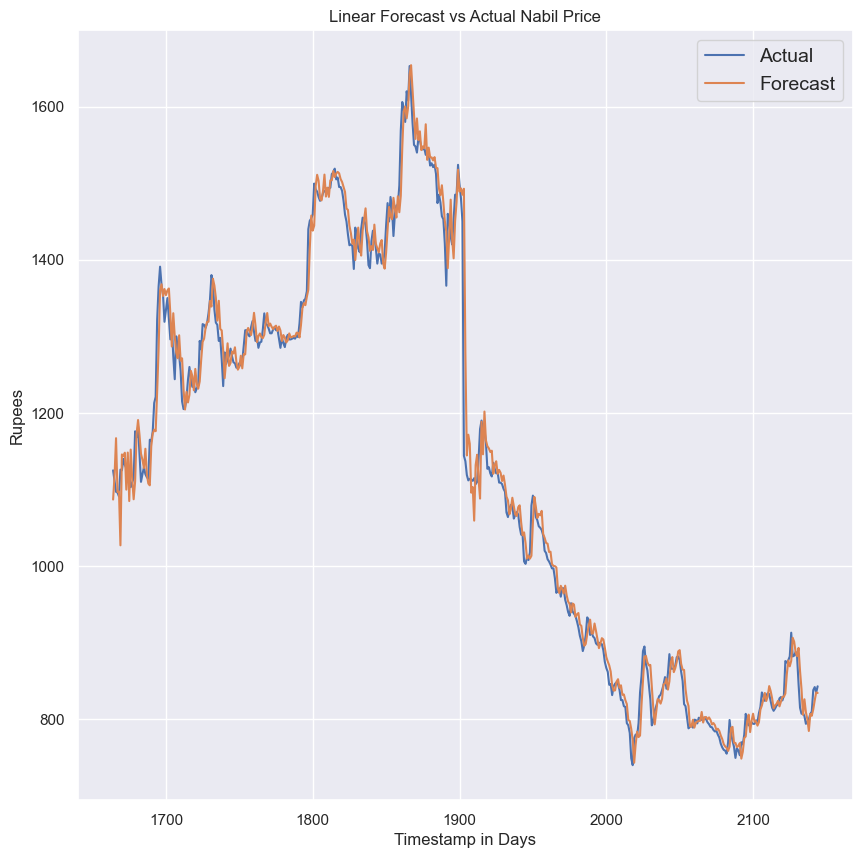

MAE FOR LINEAR FORECAST IS: 18.24583625793457


<Figure size 1000x1000 with 0 Axes>

In [128]:
# Plot results
plt.title('Linear Forecast vs Actual Nabil Price')
plt.ylabel('RUPEES')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, lin_forecast, label="Forecast")
plt.show()
plt.savefig('../Images/LINEAR/LINEAR REGRESSION FORECAST 80-20 DISTRIBUTION')

linear_mae = keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()
print(f"MAE FOR LINEAR FORECAST IS: {linear_mae}")

#### Linear Model Result

In [129]:
linear_mae = keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()
print(linear_mae)

18.245836
